DATASET OVERVIEW

Dataset Shape: (1308, 9)

Column Names:
['Country', 'Code', 'Year', 'Annual CO2 Emissions', 'Annual CO2 Emissions Per Capita', 'Birth Rate', 'GDP Per Capita', 'Percent Renewable Energy', 'Share Extreme Poverty']

First few rows:
     Country Code  Year  Annual CO2 Emissions  \
0    Algeria  DZA  1995            95905704.0   
1    Algeria  DZA  2011           124715240.0   
2  Australia  AUS  1995           304962300.0   
3  Australia  AUS  2001           357667780.0   
4  Australia  AUS  2003           370784420.0   

   Annual CO2 Emissions Per Capita  Birth Rate  GDP Per Capita  \
0                         3.368635      24.560       10588.443   
1                         3.379508      24.760       14641.964   
2                        16.853085      14.157       38585.170   
3                        18.469387      12.711       45338.684   
4                        18.708109      12.668       47500.836   

   Percent Renewable Energy  Share Extreme Poverty  
0       

C:\Users\attav\AppData\Local\Temp\ipykernel_23800\1813049426.py:73: RuntimeWarning: invalid value encountered in sqrt
  std_errors = np.sqrt(var_coef)
c:\Users\attav\anaconda3\Anaconda\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)



Diagnostic plots saved as 'regression_diagnostics.png'
Coefficient importance plot saved as 'coefficient_importance.png'

ANALYSIS COMPLETE


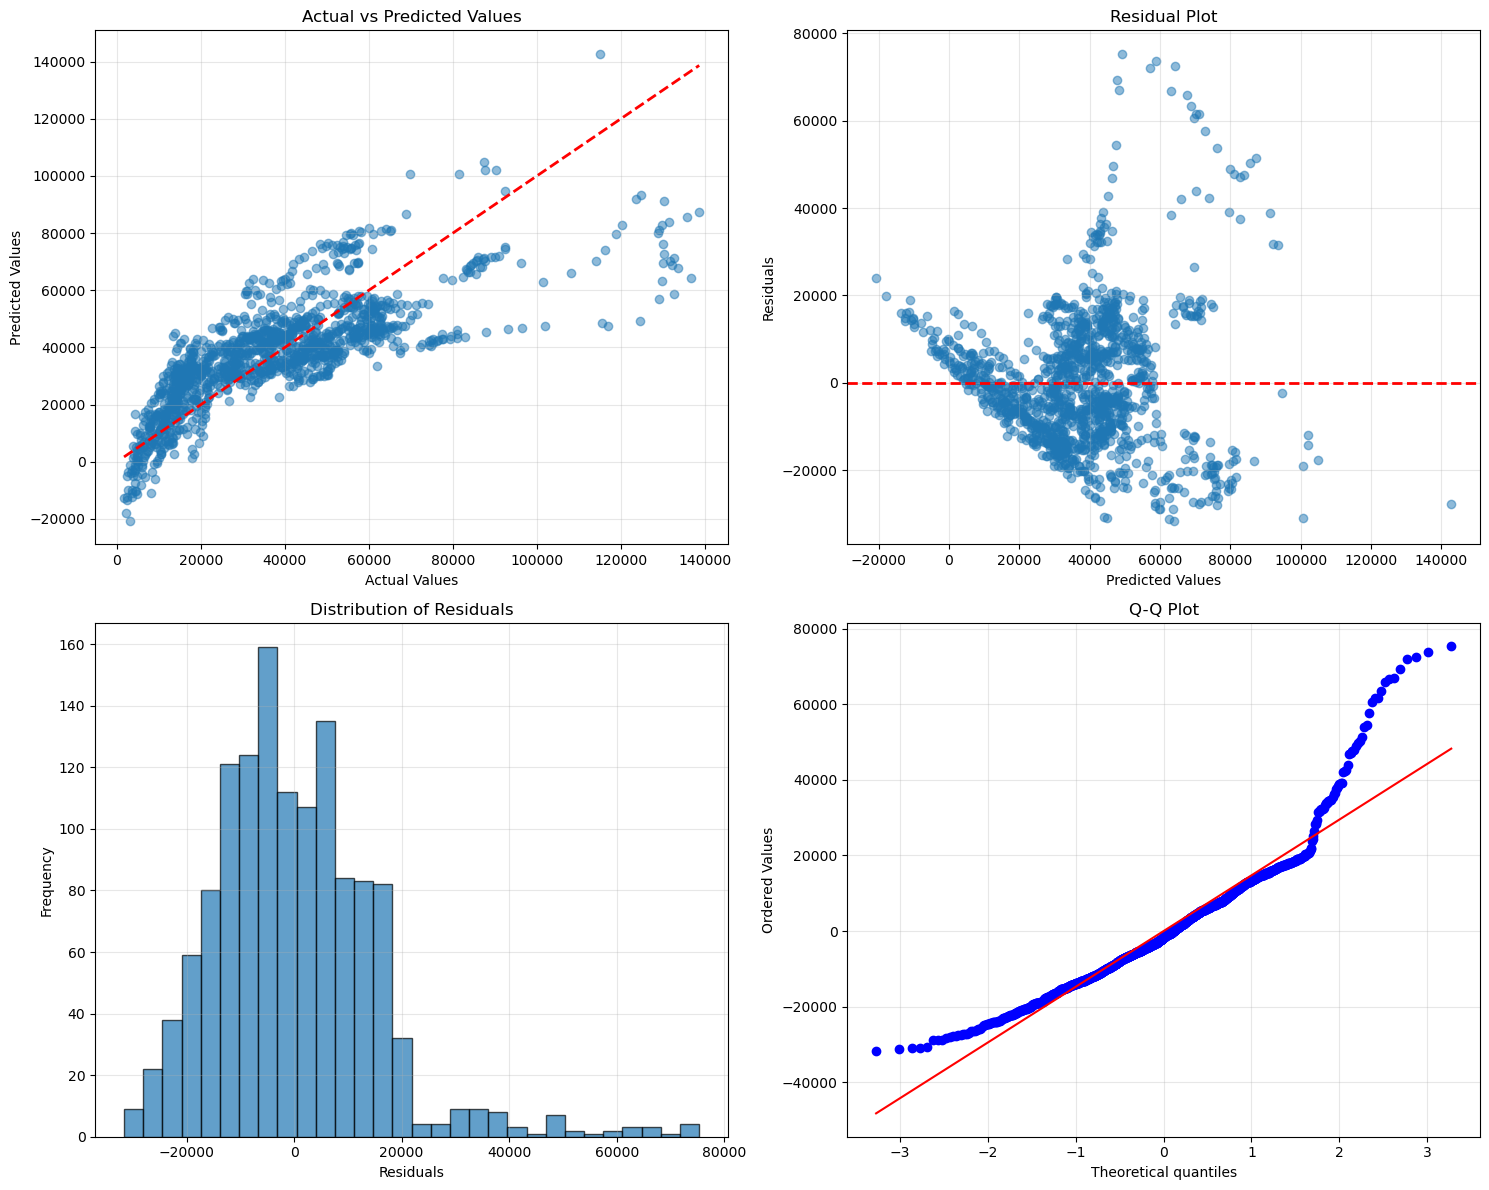

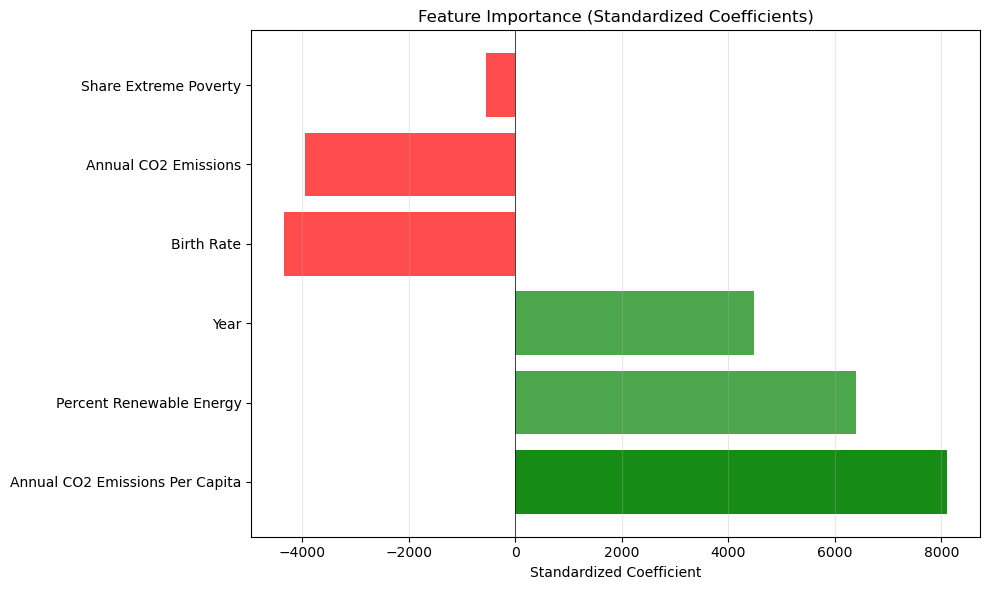

In [ ]:
#Initial regression model with all variables. 
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

file_path = 'final_dataset.xlsx'
df = pd.read_excel(file_path)

print("=" * 80)
print("DATASET OVERVIEW")
print("=" * 80)
print(f"\nDataset Shape: {df.shape}")
print(f"\nColumn Names:\n{df.columns.tolist()}")
print(f"\nFirst few rows:\n{df.head()}")
print(f"\nData Types:\n{df.dtypes}")
print(f"\nMissing Values:\n{df.isnull().sum()}")

df.columns = df.columns.str.strip()

df = df.dropna()

X_columns = ['Year', 'Annual CO2 Emissions', 'Annual CO2 Emissions Per Capita', 
             'Birth Rate', 'Percent Renewable Energy', 
             'Share Extreme Poverty','Annual CO2 Emissions Per Capita']

y_column = 'GDP Per Capita'  

X_columns = [col for col in X_columns if col != y_column]

X = df[X_columns]
y = df[y_column]

print("\n" + "=" * 80)
print("MODEL CONFIGURATION")
print("=" * 80)
print(f"\nDependent Variable (y): {y_column}")
print(f"\nIndependent Variables (X):\n{X_columns}")
print(f"\nSample Size: {len(df)}")

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X_columns)

model = LinearRegression()
model.fit(X_scaled, y)

y_pred = model.predict(X_scaled)

residuals = y - y_pred

n = len(y)
k = X.shape[1]
df_residual = n - k - 1

ss_total = np.sum((y - np.mean(y)) ** 2)
ss_residual = np.sum(residuals ** 2)
r_squared = 1 - (ss_residual / ss_total)

adj_r_squared = 1 - (1 - r_squared) * (n - 1) / df_residual

std_error = np.sqrt(ss_residual / df_residual)

mse_model = ss_total / (k)
mse_residual = ss_residual / df_residual
f_statistic = mse_model / mse_residual
f_pvalue = 1 - stats.f.cdf(f_statistic, k, df_residual)

X_with_intercept = np.column_stack([np.ones(n), X_scaled])
var_coef = mse_residual * np.linalg.inv(X_with_intercept.T @ X_with_intercept).diagonal()
std_errors = np.sqrt(var_coef)

coefficients = np.append(model.intercept_, model.coef_)
t_statistics = coefficients / std_errors
p_values = 2 * (1 - stats.t.cdf(np.abs(t_statistics), df_residual))

conf_int_lower = coefficients - 1.96 * std_errors
conf_int_upper = coefficients + 1.96 * std_errors

print("\n" + "=" * 80)
print("MODEL PERFORMANCE METRICS")
print("=" * 80)
print(f"\nR-squared: {r_squared:.6f}")
print(f"Adjusted R-squared: {adj_r_squared:.6f}")
print(f"Standard Error: {std_error:.6f}")
print(f"\nF-statistic: {f_statistic:.6f}")
print(f"F-statistic p-value: {f_pvalue:.6e}")
print(f"\nModel Significance: {'YES - Model is statistically significant' if f_pvalue < 0.05 else 'NO - Model is not statistically significant'}")

print("\n" + "=" * 80)
print("COEFFICIENT ANALYSIS")
print("=" * 80)

results_df = pd.DataFrame({
    'Variable': ['Intercept'] + X_columns,
    'Coefficient': coefficients,
    'Std Error': std_errors,
    't-statistic': t_statistics,
    'p-value': p_values,
    '95% CI Lower': conf_int_lower,
    '95% CI Upper': conf_int_upper,
    'Significant': ['YES' if p < 0.05 else 'NO' for p in p_values]
})

print("\n", results_df.to_string(index=False))

print("\n" + "=" * 80)
print("INTERPRETATION GUIDE")
print("=" * 80)
print("\n1. p-value < 0.05: Variable is statistically significant")
print("2. p-value >= 0.05: Variable is NOT statistically significant")
print("3. Positive coefficient: Positive relationship with dependent variable")
print("4. Negative coefficient: Negative relationship with dependent variable")

print("\n" + "=" * 80)
print("STATISTICAL ASSUMPTIONS CHECKS")
print("=" * 80)

shapiro_stat, shapiro_pvalue = stats.shapiro(residuals)
print(f"\nNormality Test (Shapiro-Wilk):")
print(f"  Test Statistic: {shapiro_stat:.6f}")
print(f"  p-value: {shapiro_pvalue:.6e}")
print(f"  Residuals are {'normally distributed' if shapiro_pvalue > 0.05 else 'NOT normally distributed'}")

from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["Variable"] = X_columns
vif_data["VIF"] = [variance_inflation_factor(X_scaled, i) for i in range(len(X_columns))]
print(f"\nMulticollinearity Check (VIF):")
print(vif_data.to_string(index=False))
print("\n  VIF < 5: Low multicollinearity")
print("  VIF 5-10: Moderate multicollinearity")
print("  VIF > 10: High multicollinearity (problematic)")

print("\n" + "=" * 80)
print("CORRELATION MATRIX")
print("=" * 80)
correlation_matrix = df[X_columns + [y_column]].corr()
print("\n", correlation_matrix.round(3))

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Actual vs Predicted
axes[0, 0].scatter(y, y_pred, alpha=0.5)
axes[0, 0].plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('Actual Values')
axes[0, 0].set_ylabel('Predicted Values')
axes[0, 0].set_title('Actual vs Predicted Values')
axes[0, 0].grid(True, alpha=0.3)

# 2. Residuals vs Predicted
axes[0, 1].scatter(y_pred, residuals, alpha=0.5)
axes[0, 1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0, 1].set_xlabel('Predicted Values')
axes[0, 1].set_ylabel('Residuals')
axes[0, 1].set_title('Residual Plot')
axes[0, 1].grid(True, alpha=0.3)

# 3. Histogram of residuals
axes[1, 0].hist(residuals, bins=30, edgecolor='black', alpha=0.7)
axes[1, 0].set_xlabel('Residuals')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Distribution of Residuals')
axes[1, 0].grid(True, alpha=0.3)

# 4. Q-Q plot
stats.probplot(residuals, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('regression_diagnostics.png', dpi=300, bbox_inches='tight')
print("\n" + "=" * 80)
print("Diagnostic plots saved as 'regression_diagnostics.png'")
print("=" * 80)

# Coefficient importance plot
plt.figure(figsize=(10, 6))
coef_df = pd.DataFrame({
    'Variable': X_columns,
    'Coefficient': model.coef_
}).sort_values('Coefficient', key=abs, ascending=False)

colors = ['green' if x > 0 else 'red' for x in coef_df['Coefficient']]
plt.barh(coef_df['Variable'], coef_df['Coefficient'], color=colors, alpha=0.7)
plt.xlabel('Standardized Coefficient')
plt.title('Feature Importance (Standardized Coefficients)')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.savefig('coefficient_importance.png', dpi=300, bbox_inches='tight')
print("Coefficient importance plot saved as 'coefficient_importance.png'")

print("\n" + "=" * 80)
print("ANALYSIS COMPLETE")
print("=" * 80)

DATASET OVERVIEW

Dataset Shape: (1308, 9)

Column Names:
['Country', 'Code', 'Year', 'Annual CO2 Emissions', 'Annual CO2 Emissions Per Capita', 'Birth Rate', 'GDP Per Capita', 'Percent Renewable Energy', 'Share Extreme Poverty']

First few rows:
     Country Code  Year  Annual CO2 Emissions  \
0    Algeria  DZA  1995            95905704.0   
1    Algeria  DZA  2011           124715240.0   
2  Australia  AUS  1995           304962300.0   
3  Australia  AUS  2001           357667780.0   
4  Australia  AUS  2003           370784420.0   

   Annual CO2 Emissions Per Capita  Birth Rate  GDP Per Capita  \
0                         3.368635      24.560       10588.443   
1                         3.379508      24.760       14641.964   
2                        16.853085      14.157       38585.170   
3                        18.469387      12.711       45338.684   
4                        18.708109      12.668       47500.836   

   Percent Renewable Energy  Share Extreme Poverty  
0       

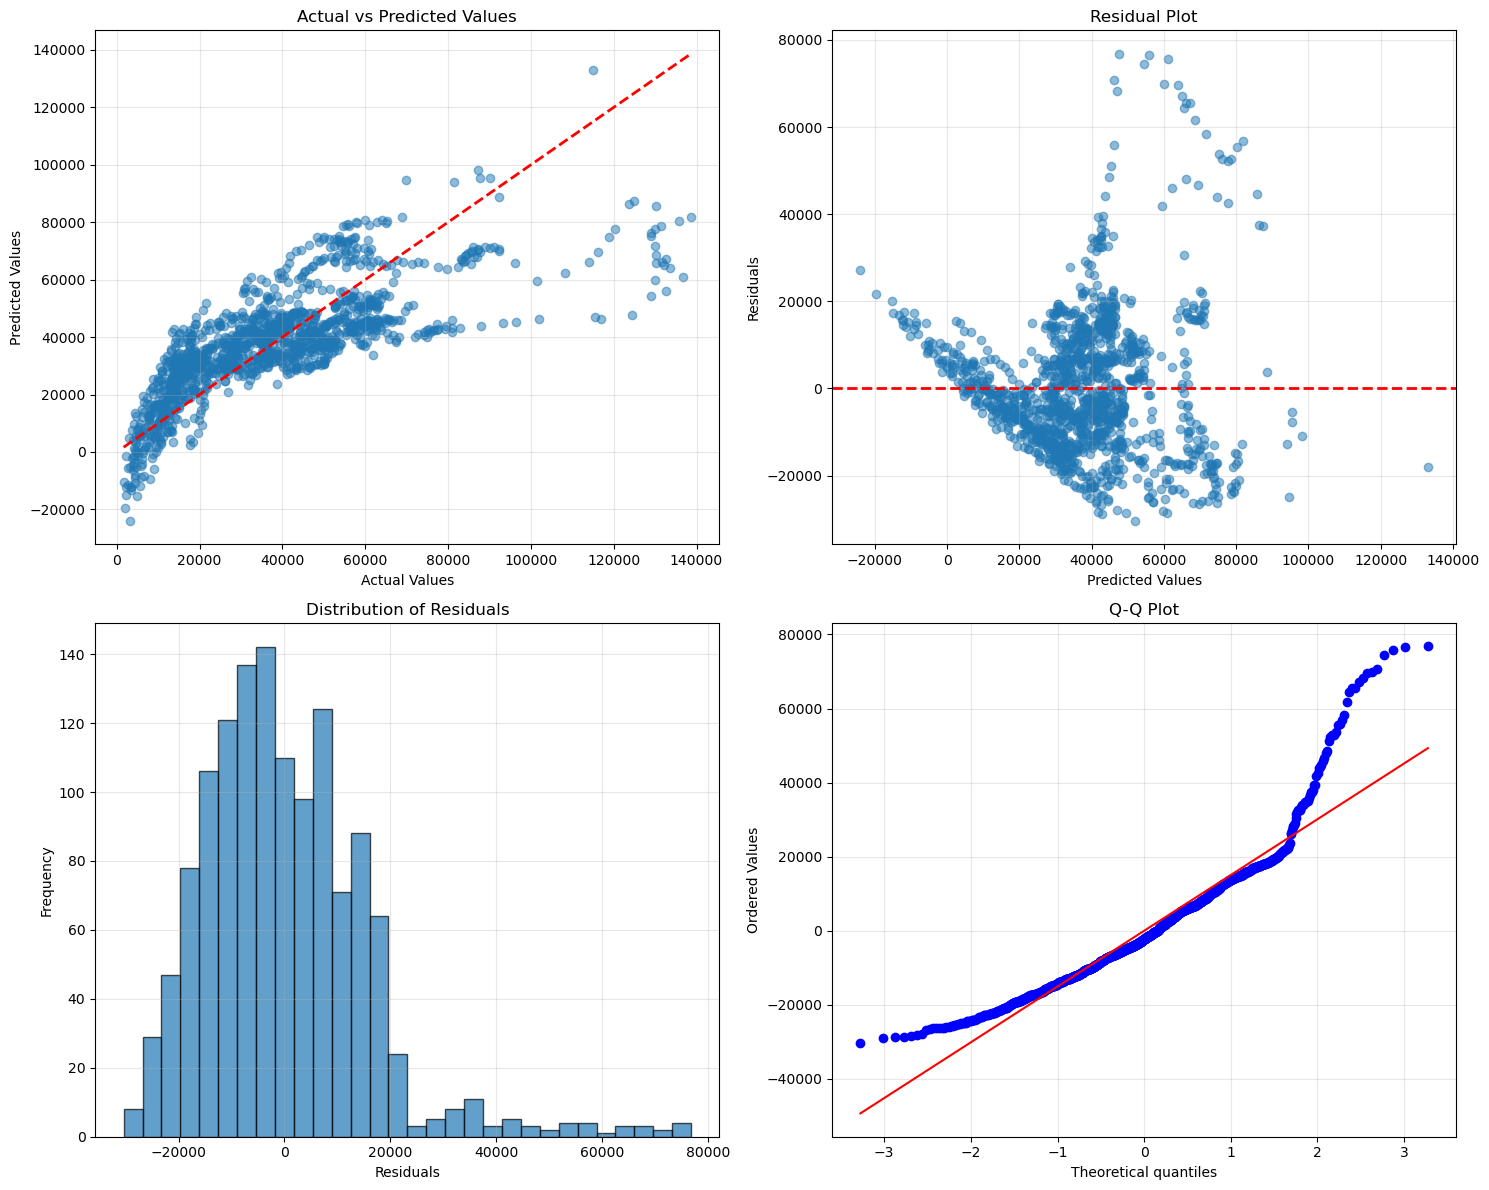

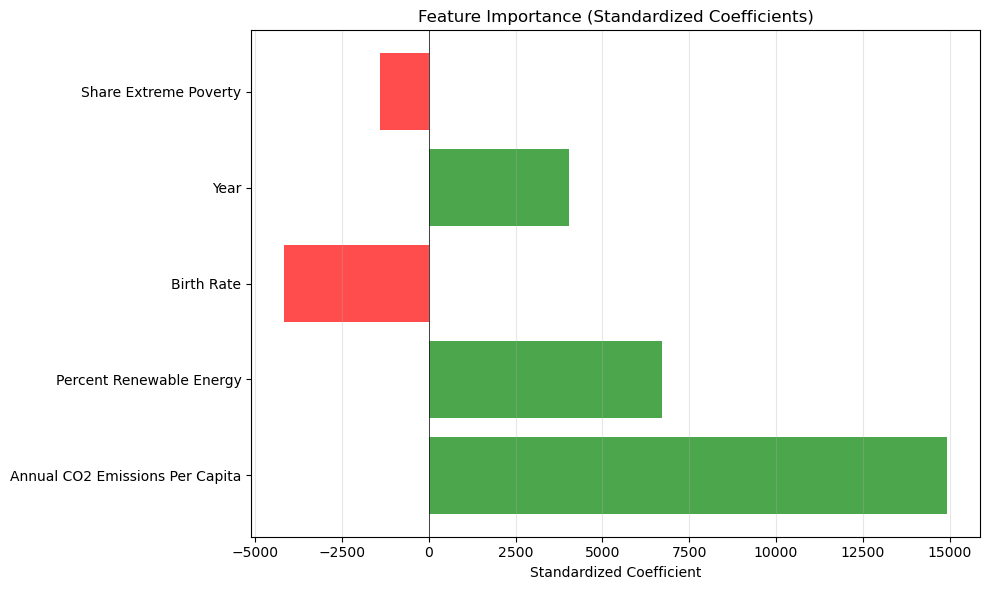

In [ ]:
#Final fitted regression model
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

file_path = 'final_dataset.xlsx'
df = pd.read_excel(file_path)

print("=" * 80)
print("DATASET OVERVIEW")
print("=" * 80)
print(f"\nDataset Shape: {df.shape}")
print(f"\nColumn Names:\n{df.columns.tolist()}")
print(f"\nFirst few rows:\n{df.head()}")
print(f"\nData Types:\n{df.dtypes}")
print(f"\nMissing Values:\n{df.isnull().sum()}")

df.columns = df.columns.str.strip()

df = df.dropna()

X_columns = ['Year', 'Annual CO2 Emissions Per Capita', 
             'Birth Rate', 'Percent Renewable Energy', 
             'Share Extreme Poverty']

y_column = 'GDP Per Capita'  

X_columns = [col for col in X_columns if col != y_column]

X = df[X_columns]
y = df[y_column]

print("\n" + "=" * 80)
print("MODEL CONFIGURATION")
print("=" * 80)
print(f"\nDependent Variable (y): {y_column}")
print(f"\nIndependent Variables (X):\n{X_columns}")
print(f"\nSample Size: {len(df)}")

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X_columns)

model = LinearRegression()
model.fit(X_scaled, y)

y_pred = model.predict(X_scaled)

residuals = y - y_pred

n = len(y)
k = X.shape[1]
df_residual = n - k - 1

ss_total = np.sum((y - np.mean(y)) ** 2)
ss_residual = np.sum(residuals ** 2)
r_squared = 1 - (ss_residual / ss_total)

adj_r_squared = 1 - (1 - r_squared) * (n - 1) / df_residual

std_error = np.sqrt(ss_residual / df_residual)

mse_model = ss_total / (k)
mse_residual = ss_residual / df_residual
f_statistic = mse_model / mse_residual
f_pvalue = 1 - stats.f.cdf(f_statistic, k, df_residual)

X_with_intercept = np.column_stack([np.ones(n), X_scaled])
var_coef = mse_residual * np.linalg.inv(X_with_intercept.T @ X_with_intercept).diagonal()
std_errors = np.sqrt(var_coef)

coefficients = np.append(model.intercept_, model.coef_)
t_statistics = coefficients / std_errors
p_values = 2 * (1 - stats.t.cdf(np.abs(t_statistics), df_residual))

conf_int_lower = coefficients - 1.96 * std_errors
conf_int_upper = coefficients + 1.96 * std_errors

print("\n" + "=" * 80)
print("MODEL PERFORMANCE METRICS")
print("=" * 80)
print(f"\nR-squared: {r_squared:.6f}")
print(f"Adjusted R-squared: {adj_r_squared:.6f}")
print(f"Standard Error: {std_error:.6f}")
print(f"\nF-statistic: {f_statistic:.6f}")
print(f"F-statistic p-value: {f_pvalue:.6e}")
print(f"\nModel Significance: {'YES - Model is statistically significant' if f_pvalue < 0.05 else 'NO - Model is not statistically significant'}")

print("\n" + "=" * 80)
print("COEFFICIENT ANALYSIS")
print("=" * 80)

results_df = pd.DataFrame({
    'Variable': ['Intercept'] + X_columns,
    'Coefficient': coefficients,
    'Std Error': std_errors,
    't-statistic': t_statistics,
    'p-value': p_values,
    '95% CI Lower': conf_int_lower,
    '95% CI Upper': conf_int_upper,
    'Significant': ['YES' if p < 0.05 else 'NO' for p in p_values]
})

print("\n", results_df.to_string(index=False))

print("\n" + "=" * 80)
print("INTERPRETATION GUIDE")
print("=" * 80)
print("\n1. p-value < 0.05: Variable is statistically significant")
print("2. p-value >= 0.05: Variable is NOT statistically significant")
print("3. Positive coefficient: Positive relationship with dependent variable")
print("4. Negative coefficient: Negative relationship with dependent variable")

print("\n" + "=" * 80)
print("STATISTICAL ASSUMPTIONS CHECKS")
print("=" * 80)

shapiro_stat, shapiro_pvalue = stats.shapiro(residuals)
print(f"\nNormality Test (Shapiro-Wilk):")
print(f"  Test Statistic: {shapiro_stat:.6f}")
print(f"  p-value: {shapiro_pvalue:.6e}")
print(f"  Residuals are {'normally distributed' if shapiro_pvalue > 0.05 else 'NOT normally distributed'}")

from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["Variable"] = X_columns
vif_data["VIF"] = [variance_inflation_factor(X_scaled, i) for i in range(len(X_columns))]
print(f"\nMulticollinearity Check (VIF):")
print(vif_data.to_string(index=False))
print("\n  VIF < 5: Low multicollinearity")
print("  VIF 5-10: Moderate multicollinearity")
print("  VIF > 10: High multicollinearity (problematic)")

print("\n" + "=" * 80)
print("CORRELATION MATRIX")
print("=" * 80)
correlation_matrix = df[X_columns + [y_column]].corr()
print("\n", correlation_matrix.round(3))

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Actual vs Predicted
axes[0, 0].scatter(y, y_pred, alpha=0.5)
axes[0, 0].plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('Actual Values')
axes[0, 0].set_ylabel('Predicted Values')
axes[0, 0].set_title('Actual vs Predicted Values')
axes[0, 0].grid(True, alpha=0.3)

# 2. Residuals vs Predicted
axes[0, 1].scatter(y_pred, residuals, alpha=0.5)
axes[0, 1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0, 1].set_xlabel('Predicted Values')
axes[0, 1].set_ylabel('Residuals')
axes[0, 1].set_title('Residual Plot')
axes[0, 1].grid(True, alpha=0.3)

# 3. Histogram of residuals
axes[1, 0].hist(residuals, bins=30, edgecolor='black', alpha=0.7)
axes[1, 0].set_xlabel('Residuals')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Distribution of Residuals')
axes[1, 0].grid(True, alpha=0.3)

# 4. Q-Q plot
stats.probplot(residuals, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('regression_diagnostics.png', dpi=300, bbox_inches='tight')
print("\n" + "=" * 80)
print("Diagnostic plots saved as 'regression_diagnostics.png'")
print("=" * 80)

# Coefficient importance plot
plt.figure(figsize=(10, 6))
coef_df = pd.DataFrame({
    'Variable': X_columns,
    'Coefficient': model.coef_
}).sort_values('Coefficient', key=abs, ascending=False)

colors = ['green' if x > 0 else 'red' for x in coef_df['Coefficient']]
plt.barh(coef_df['Variable'], coef_df['Coefficient'], color=colors, alpha=0.7)
plt.xlabel('Standardized Coefficient')
plt.title('Feature Importance (Standardized Coefficients)')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.savefig('coefficient_importance.png', dpi=300, bbox_inches='tight')
print("Coefficient importance plot saved as 'coefficient_importance.png'")

print("\n" + "=" * 80)
print("ANALYSIS COMPLETE")
print("=" * 80)

DATASET OVERVIEW

Dataset Shape: (1308, 9)

Column Names:
['Country', 'Code', 'Year', 'Annual CO2 Emissions', 'Annual CO2 Emissions Per Capita', 'Birth Rate', 'GDP Per Capita', 'Percent Renewable Energy', 'Share Extreme Poverty']

First few rows:
     Country Code  Year  Annual CO2 Emissions  \
0    Algeria  DZA  1995            95905704.0   
1    Algeria  DZA  2011           124715240.0   
2  Australia  AUS  1995           304962300.0   
3  Australia  AUS  2001           357667780.0   
4  Australia  AUS  2003           370784420.0   

   Annual CO2 Emissions Per Capita  Birth Rate  GDP Per Capita  \
0                         3.368635      24.560       10588.443   
1                         3.379508      24.760       14641.964   
2                        16.853085      14.157       38585.170   
3                        18.469387      12.711       45338.684   
4                        18.708109      12.668       47500.836   

   Percent Renewable Energy  Share Extreme Poverty  
0       

c:\Users\attav\anaconda3\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\attav\anaconda3\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\attav\anaconda3\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


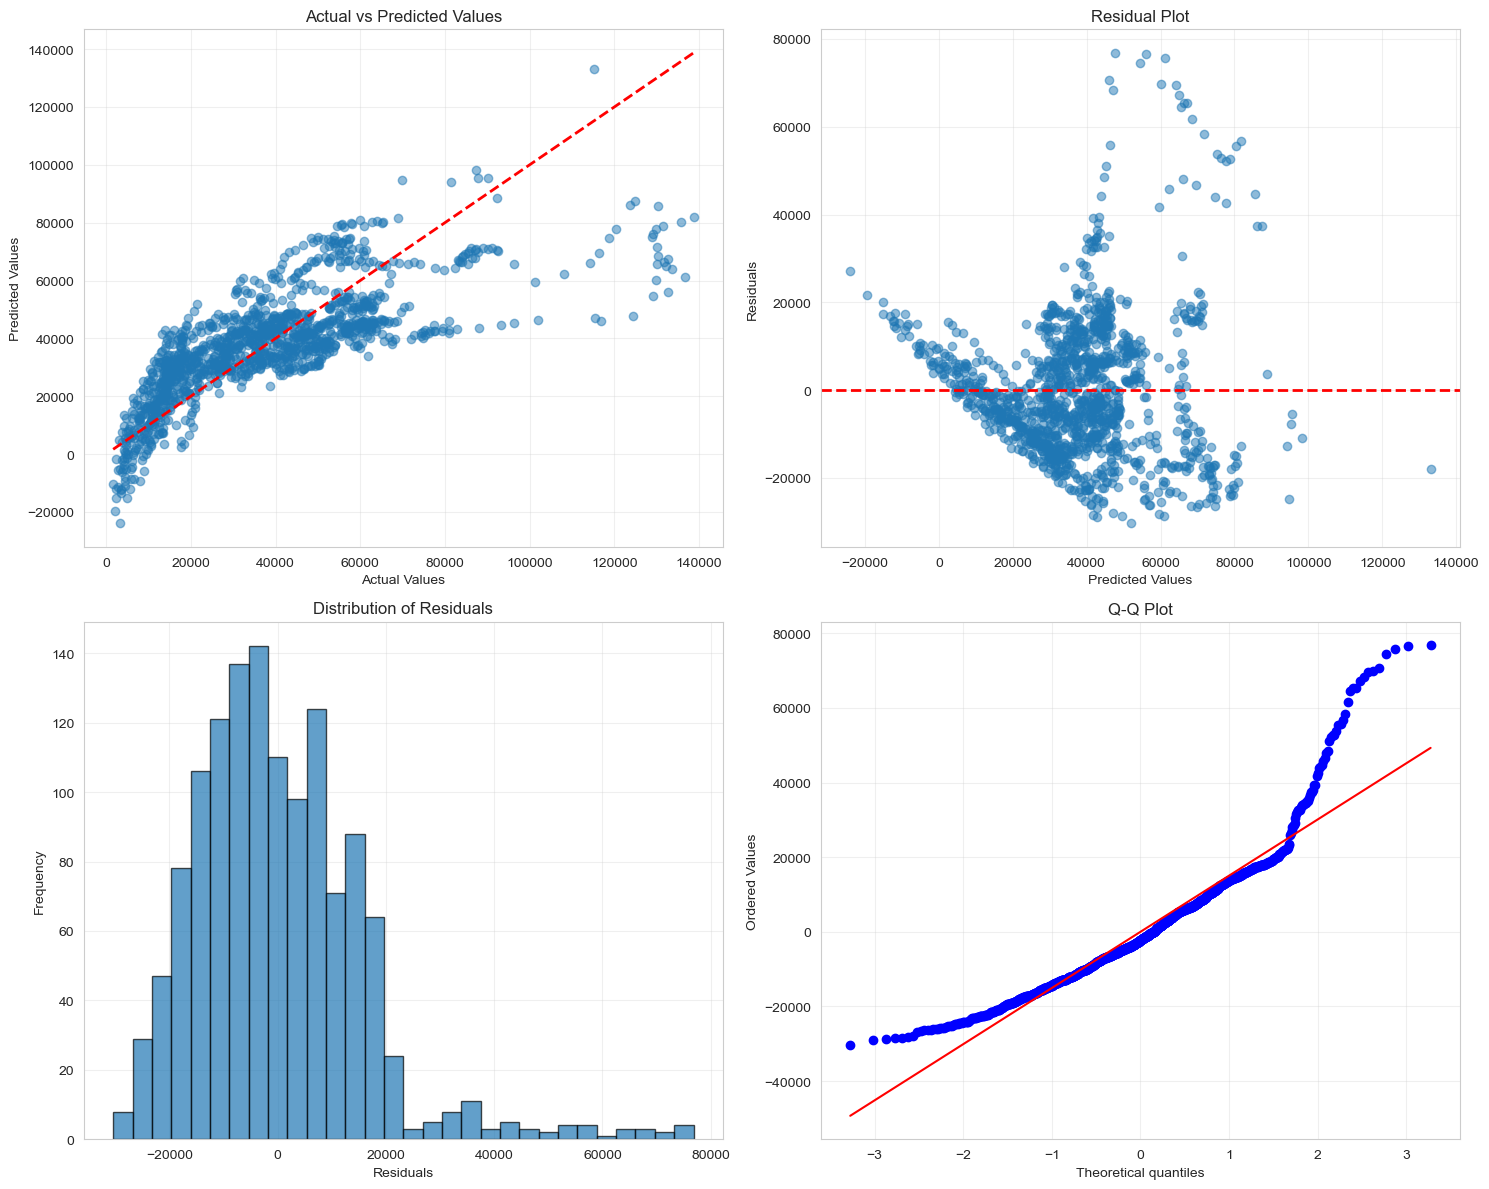

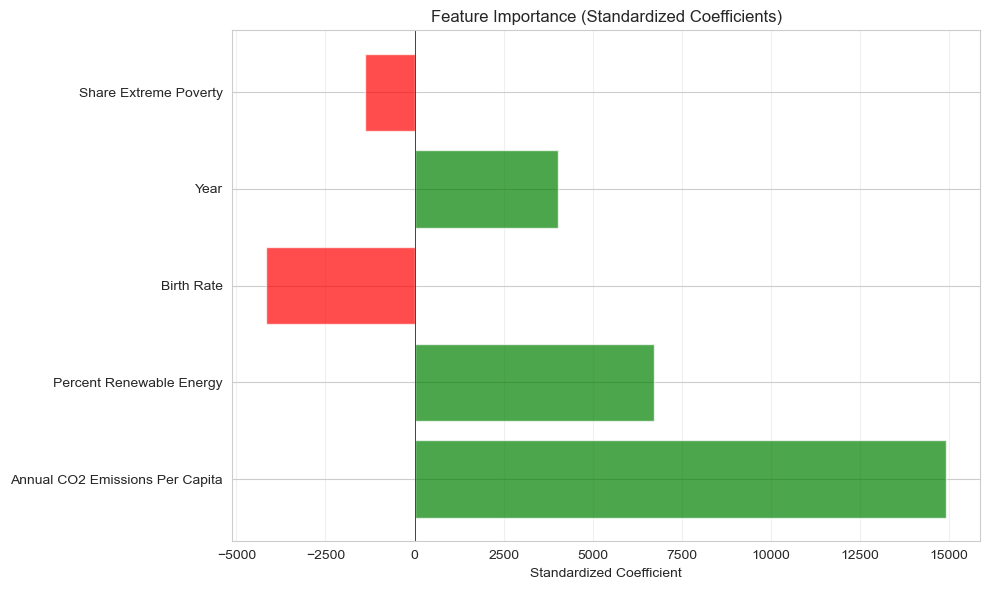

In [ ]:
#Our Model Predictions
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

file_path = 'final_dataset.xlsx'
df = pd.read_excel(file_path)

print("=" * 80)
print("DATASET OVERVIEW")
print("=" * 80)
print(f"\nDataset Shape: {df.shape}")
print(f"\nColumn Names:\n{df.columns.tolist()}")
print(f"\nFirst few rows:\n{df.head()}")
print(f"\nData Types:\n{df.dtypes}")
print(f"\nMissing Values:\n{df.isnull().sum()}")

df.columns = df.columns.str.strip()

df = df.dropna()

X_columns = ['Year', 'Annual CO2 Emissions Per Capita', 
             'Birth Rate', 'Percent Renewable Energy', 
             'Share Extreme Poverty']

y_column = 'GDP Per Capita'

X_columns = [col for col in X_columns if col != y_column]

X = df[X_columns]
y = df[y_column]

print("\n" + "=" * 80)
print("MODEL CONFIGURATION")
print("=" * 80)
print(f"\nDependent Variable (y): {y_column}")
print(f"\nIndependent Variables (X):\n{X_columns}")
print(f"\nSample Size: {len(df)}")

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X_columns)

model = LinearRegression()
model.fit(X_scaled, y)

y_pred = model.predict(X_scaled)

residuals = y - y_pred

n = len(y)
k = X.shape[1]
df_residual = n - k - 1

ss_total = np.sum((y - np.mean(y)) ** 2)
ss_residual = np.sum(residuals ** 2)
r_squared = 1 - (ss_residual / ss_total)

adj_r_squared = 1 - (1 - r_squared) * (n - 1) / df_residual

std_error = np.sqrt(ss_residual / df_residual)

mse_model = ss_total / (k)
mse_residual = ss_residual / df_residual
f_statistic = mse_model / mse_residual
f_pvalue = 1 - stats.f.cdf(f_statistic, k, df_residual)

X_with_intercept = np.column_stack([np.ones(n), X_scaled])
var_coef = mse_residual * np.linalg.inv(X_with_intercept.T @ X_with_intercept).diagonal()
std_errors = np.sqrt(var_coef)

coefficients = np.append(model.intercept_, model.coef_)
t_statistics = coefficients / std_errors
p_values = 2 * (1 - stats.t.cdf(np.abs(t_statistics), df_residual))

conf_int_lower = coefficients - 1.96 * std_errors
conf_int_upper = coefficients + 1.96 * std_errors

print("\n" + "=" * 80)
print("MODEL PERFORMANCE METRICS")
print("=" * 80)
print(f"\nR-squared: {r_squared:.6f}")
print(f"  → Model explains {r_squared*100:.2f}% of variance in {y_column}")
print(f"\nAdjusted R-squared: {adj_r_squared:.6f}")
print(f"Standard Error: {std_error:.6f}")
print(f"\nF-statistic: {f_statistic:.6f}")
print(f"F-statistic p-value: {f_pvalue:.6e}")
print(f"\nModel Significance: {'✓ YES - Model is statistically significant' if f_pvalue < 0.05 else '✗ NO - Model is not statistically significant'}")

print("\n" + "=" * 80)
print("COEFFICIENT ANALYSIS")
print("=" * 80)

results_df = pd.DataFrame({
    'Variable': ['Intercept'] + X_columns,
    'Coefficient': coefficients,
    'Std Error': std_errors,
    't-statistic': t_statistics,
    'p-value': p_values,
    '95% CI Lower': conf_int_lower,
    '95% CI Upper': conf_int_upper,
    'Significant': ['✓ YES' if p < 0.05 else '✗ NO' for p in p_values]
})

print("\n", results_df.to_string(index=False))

print("\n" + "=" * 80)
print("INTERPRETATION GUIDE")
print("=" * 80)
print("\n1. p-value < 0.05: Variable is statistically significant")
print("2. p-value >= 0.05: Variable is NOT statistically significant")
print("3. Positive coefficient: Positive relationship with dependent variable")
print("4. Negative coefficient: Negative relationship with dependent variable")

print("\n" + "=" * 80)
print("STATISTICAL ASSUMPTIONS CHECKS")
print("=" * 80)

shapiro_stat, shapiro_pvalue = stats.shapiro(residuals)
print(f"\nNormality Test (Shapiro-Wilk):")
print(f"  Test Statistic: {shapiro_stat:.6f}")
print(f"  p-value: {shapiro_pvalue:.6e}")
print(f"  Residuals are {'normally distributed' if shapiro_pvalue > 0.05 else 'NOT normally distributed'}")

from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["Variable"] = X_columns
vif_data["VIF"] = [variance_inflation_factor(X_scaled, i) for i in range(len(X_columns))]
print(f"\nMulticollinearity Check (VIF):")
print(vif_data.to_string(index=False))
print("\n  VIF < 5: Low multicollinearity")
print("  VIF 5-10: Moderate multicollinearity")
print("  VIF > 10: High multicollinearity (problematic)")

print("\n" + "=" * 80)
print("CORRELATION MATRIX")
print("=" * 80)
correlation_matrix = df[X_columns + [y_column]].corr()
print("\n", correlation_matrix.round(3))

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

axes[0, 0].scatter(y, y_pred, alpha=0.5)
axes[0, 0].plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('Actual Values')
axes[0, 0].set_ylabel('Predicted Values')
axes[0, 0].set_title('Actual vs Predicted Values')
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].scatter(y_pred, residuals, alpha=0.5)
axes[0, 1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0, 1].set_xlabel('Predicted Values')
axes[0, 1].set_ylabel('Residuals')
axes[0, 1].set_title('Residual Plot')
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].hist(residuals, bins=30, edgecolor='black', alpha=0.7)
axes[1, 0].set_xlabel('Residuals')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Distribution of Residuals')
axes[1, 0].grid(True, alpha=0.3)

stats.probplot(residuals, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('regression_diagnostics.png', dpi=300, bbox_inches='tight')
print("\n" + "=" * 80)
print("Diagnostic plots saved as 'regression_diagnostics.png'")
print("=" * 80)

plt.figure(figsize=(10, 6))
coef_df = pd.DataFrame({
    'Variable': X_columns,
    'Coefficient': model.coef_
}).sort_values('Coefficient', key=abs, ascending=False)

colors = ['green' if x > 0 else 'red' for x in coef_df['Coefficient']]
plt.barh(coef_df['Variable'], coef_df['Coefficient'], color=colors, alpha=0.7)
plt.xlabel('Standardized Coefficient')
plt.title('Feature Importance (Standardized Coefficients)')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.savefig('coefficient_importance.png', dpi=300, bbox_inches='tight')
print("Coefficient importance plot saved as 'coefficient_importance.png'")

# ============================================================================
# PREDICTION FUNCTION FOR ANY ROW
# ============================================================================

def predict_gdp_for_row(input_values):
    """
    Predict GDP Per Capita for any set of input values
    
    Parameters:
    -----------
    input_values : dict
        Dictionary with keys matching X_columns
        Example: {'Year': 2020, 'Annual CO2 Emissions Per Capita': 15.5, ...}
    
    Returns:
    --------
    float : Predicted GDP Per Capita
    """
    input_array = np.array([input_values[col] for col in X_columns]).reshape(1, -1)
    
    input_scaled = scaler.transform(input_array)

    prediction = model.predict(input_scaled)[0]
    
    return prediction

# ============================================================================
# EXAMPLE PREDICTIONS FOR SPECIFIC ROWS
# ============================================================================

print("\n" + "=" * 80)
print("PREDICTIONS FOR SPECIFIC ROWS")
print("=" * 80)

print("\n" + "=" * 80)
print("EXAMPLE 1: Predicting for Row 1")
print("=" * 80)

row_idx = 0 
print(f"\nCountry: {df['Country'].iloc[row_idx]}")
print(f"Year: {df['Year'].iloc[row_idx]}")
print(f"\nInput Features:")

row_1_inputs = {}
for col in X_columns:
    value = df[col].iloc[row_idx]
    row_1_inputs[col] = value
    print(f"  {col}: {value}")

predicted_gdp_1 = predict_gdp_for_row(row_1_inputs)
actual_gdp_1 = df[y_column].iloc[row_idx]

print(f"\n{'='*50}")
print(f"PREDICTED GDP Per Capita: ${predicted_gdp_1:,.2f}")
print(f"ACTUAL GDP Per Capita:    ${actual_gdp_1:,.2f}")
print(f"{'='*50}")
print(f"Prediction Error: ${abs(predicted_gdp_1 - actual_gdp_1):,.2f}")
print(f"Percentage Error: {abs((predicted_gdp_1 - actual_gdp_1) / actual_gdp_1) * 100:.2f}%")

print("\n" + "=" * 80)
print("EXAMPLE 2: Predicting for Row 10")
print("=" * 80)

row_idx = 9 
print(f"\nCountry: {df['Country'].iloc[row_idx]}")
print(f"Year: {df['Year'].iloc[row_idx]}")
print(f"\nInput Features:")

row_10_inputs = {}
for col in X_columns:
    value = df[col].iloc[row_idx]
    row_10_inputs[col] = value
    print(f"  {col}: {value}")

predicted_gdp_10 = predict_gdp_for_row(row_10_inputs)
actual_gdp_10 = df[y_column].iloc[row_idx]

print(f"\n{'='*50}")
print(f"PREDICTED GDP Per Capita: ${predicted_gdp_10:,.2f}")
print(f"ACTUAL GDP Per Capita:    ${actual_gdp_10:,.2f}")
print(f"{'='*50}")
print(f"Prediction Error: ${abs(predicted_gdp_10 - actual_gdp_10):,.2f}")
print(f"Percentage Error: {abs((predicted_gdp_10 - actual_gdp_10) / actual_gdp_10) * 100:.2f}%")

print("\n" + "=" * 80)
print("EXAMPLE 3: Custom Hypothetical Scenario")
print("=" * 80)

custom_inputs = {
    'Year': 2025,
    'Annual CO2 Emissions Per Capita': 10.0,
    'Birth Rate': 12.0,
    'Percent Renewable Energy': 25.0,
    'Share Extreme Poverty': 0.5
}

print("\nHypothetical Scenario:")
for key, value in custom_inputs.items():
    print(f"  {key}: {value}")

predicted_gdp_custom = predict_gdp_for_row(custom_inputs)

print(f"\n{'='*50}")
print(f"PREDICTED GDP Per Capita: ${predicted_gdp_custom:,.2f}")
print(f"{'='*50}")

# ============================================================================
# PREDICTIONS FOR ALL ROWS IN DATASET
# ============================================================================

print("\n" + "=" * 80)
print("PREDICTIONS FOR ALL ROWS (showing first 25)")
print("=" * 80)

all_predictions = model.predict(X_scaled)

predictions_df = pd.DataFrame({
    'Row': range(len(df)),
    'Country': df['Country'].values,
    'Year': df['Year'].values,
    'Actual_GDP': df[y_column].values,
    'Predicted_GDP': all_predictions,
    'Error': df[y_column].values - all_predictions,
    'Abs_Error': np.abs(df[y_column].values - all_predictions),
    'Percent_Error': np.abs((df[y_column].values - all_predictions) / df[y_column].values * 100)
})

print("\n", predictions_df.head(25).to_string(index=False))

# ============================================================================
# PREDICTION ACCURACY SUMMARY
# ============================================================================

print("\n" + "=" * 80)
print("OVERALL PREDICTION ACCURACY SUMMARY")
print("=" * 80)

print(f"\nTotal Predictions Made: {len(predictions_df)}")
print(f"\nMean Absolute Error (MAE): ${predictions_df['Abs_Error'].mean():,.2f}")
print(f"Root Mean Squared Error (RMSE): ${np.sqrt(np.mean(predictions_df['Error']**2)):,.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {predictions_df['Percent_Error'].mean():.2f}%")
print(f"Median Absolute Percentage Error: {predictions_df['Percent_Error'].median():.2f}%")

best_pred_idx = predictions_df['Abs_Error'].idxmin()
worst_pred_idx = predictions_df['Abs_Error'].idxmax()

print(f"\nBest Prediction:")
print(f"  Row {predictions_df.loc[best_pred_idx, 'Row']}: {predictions_df.loc[best_pred_idx, 'Country']} ({predictions_df.loc[best_pred_idx, 'Year']})")
print(f"  Error: ${predictions_df.loc[best_pred_idx, 'Abs_Error']:,.2f} ({predictions_df.loc[best_pred_idx, 'Percent_Error']:.2f}%)")

print(f"\nWorst Prediction:")
print(f"  Row {predictions_df.loc[worst_pred_idx, 'Row']}: {predictions_df.loc[worst_pred_idx, 'Country']} ({predictions_df.loc[worst_pred_idx, 'Year']})")
print(f"  Error: ${predictions_df.loc[worst_pred_idx, 'Abs_Error']:,.2f} ({predictions_df.loc[worst_pred_idx, 'Percent_Error']:.2f}%)")

predictions_df.to_csv('all_gdp_predictions.csv', index=False)
print(f"\n✓ All predictions saved to 'all_gdp_predictions.csv'")

# ============================================================================
# HOW TO USE THIS MODEL FOR NEW PREDICTIONS
# ============================================================================

print("\n" + "=" * 80)
print("HOW TO PREDICT GDP FOR ANY ROW")
print("=" * 80)

print("""
To predict GDP Per Capita for any row, use the predict_gdp_for_row() function:

EXAMPLE CODE:
-------------
# For a specific row number (e.g., row 50):
row_number = 50
inputs = {col: df[col].iloc[row_number] for col in X_columns}
predicted_gdp = predict_gdp_for_row(inputs)
print(f"Predicted GDP: ${predicted_gdp:,.2f}")

# For custom values:
my_inputs = {
    'Year': 2030,
    'Annual CO2 Emissions Per Capita': 8.5,
    'Birth Rate': 10.5,
    'Percent Renewable Energy': 40.0,
    'Share Extreme Poverty': 0.2
}
predicted_gdp = predict_gdp_for_row(my_inputs)
print(f"Predicted GDP: ${predicted_gdp:,.2f}")
""")

print("\n" + "=" * 80)
print("✓ ANALYSIS AND PREDICTIONS COMPLETE")
print("=" * 80)

print(f"""
SUMMARY:
--------
• Model predicts: {y_column}
• Using {len(X_columns)} predictors
• Model explains {r_squared*100:.2f}% of variance (R²)
• Average prediction error: {predictions_df['Percent_Error'].mean():.2f}%
• Total predictions generated: {len(predictions_df)}

FILES SAVED:
------------
✓ regression_diagnostics.png - Model diagnostic plots
✓ coefficient_importance.png - Feature importance chart
✓ all_gdp_predictions.csv - Complete predictions for all rows
""")


COMPREHENSIVE RESIDUAL ANALYSIS

✓ Comprehensive residual plots saved as 'comprehensive_residual_analysis.png'

RESIDUAL DIAGNOSTICS SUMMARY

1. NORMALITY TESTS:
   Shapiro-Wilk Test:
     • Statistic: 0.933594
     • p-value: 1.124156e-23
     • Result: ✗ Not Normal

   Jarque-Bera Test:
     • Statistic: 913.707370
     • p-value: 3.899111e-199
     • Result: ✗ Not Normal

2. HOMOSCEDASTICITY:
   Correlation test (fitted vs |residuals|):
     • Correlation: 0.433537
     • p-value: 4.587927e-61
     • Result: ✗ Heteroscedastic

3. INFLUENTIAL POINTS:
   Cook's Distance > 0.5: 0 observations
   Cook's Distance > 1.0: 0 observations

4. OUTLIERS:
   |Standardized Residuals| > 3: 23 observations (1.76%)

5. RESIDUAL STATISTICS:
   Mean: 0.000000 (should be ≈ 0)
   Std Dev: 15221.921433
   Min: -31640.35
   Max: 75335.96
   Range: 106976.31

✓ RESIDUAL ANALYSIS COMPLETE


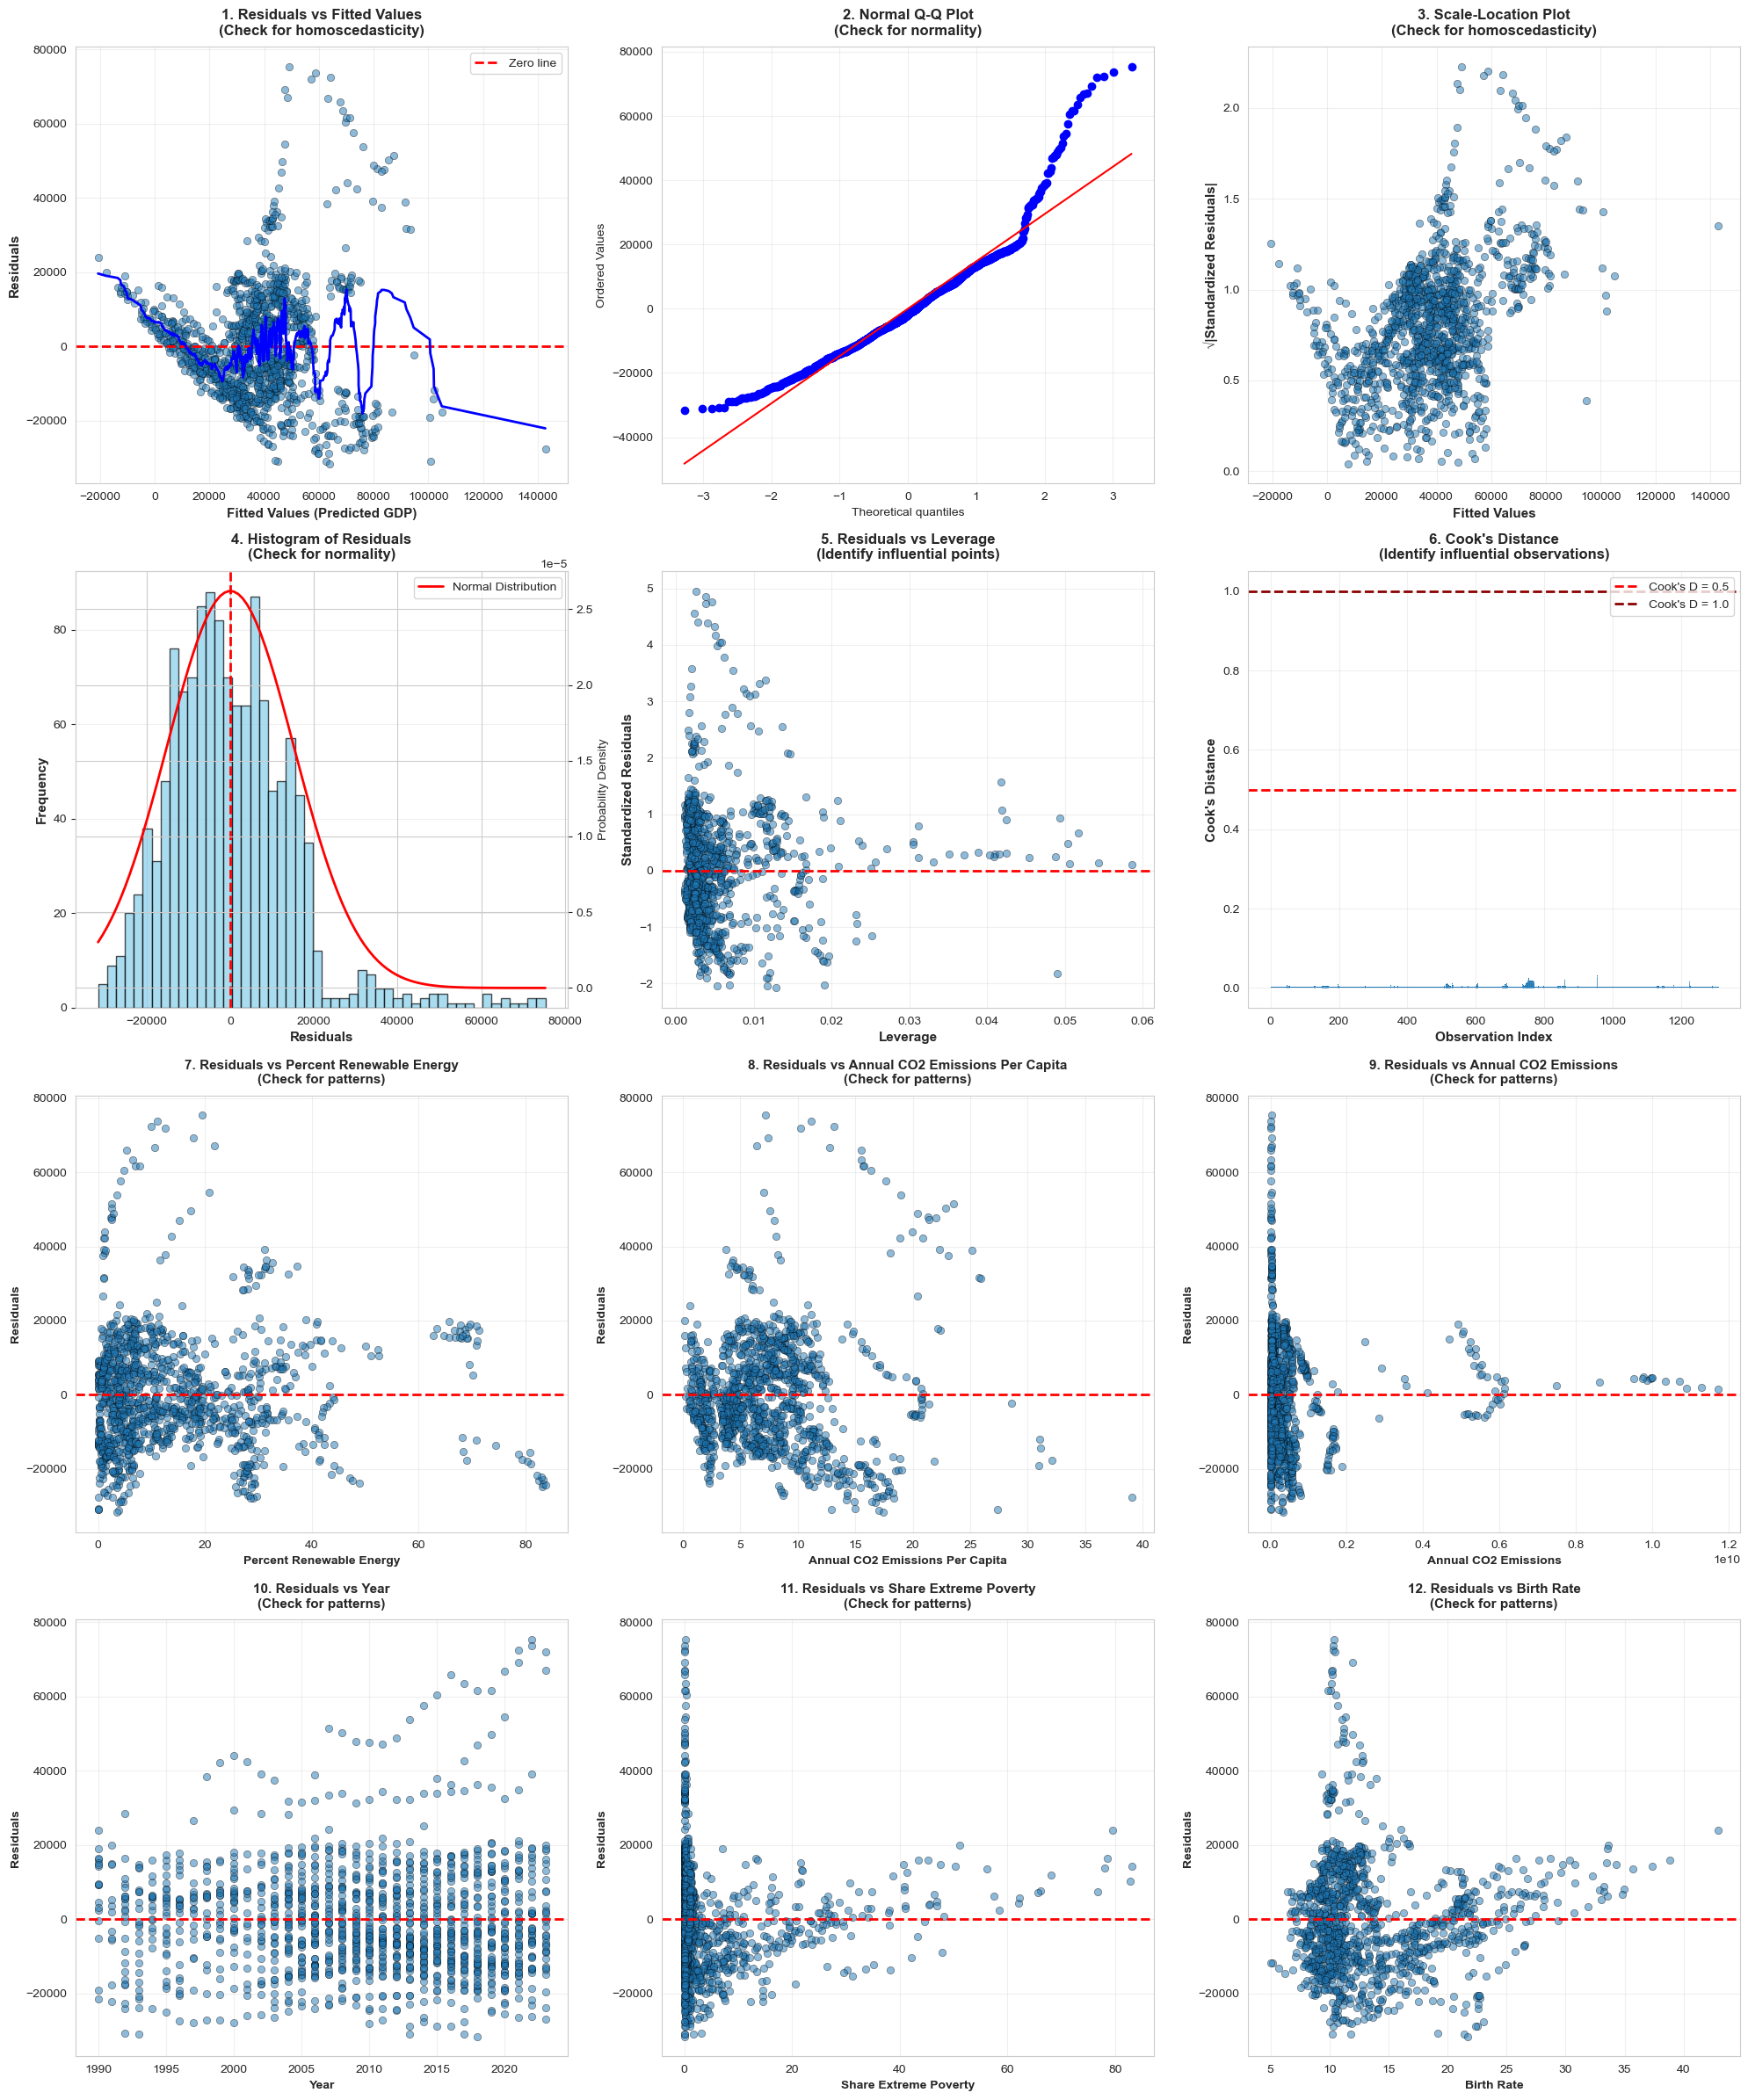

In [ ]:
#IMPLEMENTING COMPREHENSIVE RESIDUAL PLOTS - Initial Model 

file_path = 'final_dataset.xlsx'
df = pd.read_excel(file_path)
df.columns = df.columns.str.strip()
df = df.dropna()

# X_columns = ['Year', 'Annual CO2 Emissions Per Capita', 
#              'Birth Rate', 'Percent Renewable Energy', 
#              'Share Extreme Poverty']

# y_column = 'GDP Per Capita'  # You can change this to any dependent variable
X_columns = ['Year', 'Annual CO2 Emissions', 'Annual CO2 Emissions Per Capita', 
             'Birth Rate', 'Percent Renewable Energy', 'Share Extreme Poverty']

y_column = 'GDP Per Capita'

X_columns = list(set(X_columns))  
X_columns = [col for col in X_columns if col != y_column]

X = df[X_columns]
y = df[y_column]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

model = LinearRegression()
model.fit(X_scaled, y)

y_pred = model.predict(X_scaled)
residuals = y - y_pred

standardized_residuals = residuals / np.std(residuals)

X_with_intercept = np.column_stack([np.ones(len(X)), X_scaled])
hat_matrix = X_with_intercept @ np.linalg.inv(X_with_intercept.T @ X_with_intercept) @ X_with_intercept.T
leverage = np.diag(hat_matrix)

n = len(y)
k = X.shape[1]
mse = np.sum(residuals**2) / (n - k - 1)
cooks_d = (standardized_residuals**2 / k) * (leverage / (1 - leverage)**2)

print("\n" + "=" * 80)
print("COMPREHENSIVE RESIDUAL ANALYSIS")
print("=" * 80)

# ============================================================================
# CREATE COMPREHENSIVE RESIDUAL PLOTS
# ============================================================================

sns.set_style("whitegrid")
plt.rcParams['figure.facecolor'] = 'white'

fig = plt.figure(figsize=(20, 24))

# ────────────────────────────────────────────────────────────────────────────
# PLOT 1: Residuals vs Fitted Values
# ────────────────────────────────────────────────────────────────────────────
ax1 = plt.subplot(4, 3, 1)
ax1.scatter(y_pred, residuals, alpha=0.5, edgecolors='k', linewidths=0.5)
ax1.axhline(y=0, color='red', linestyle='--', linewidth=2, label='Zero line')
ax1.set_xlabel('Fitted Values (Predicted GDP)', fontsize=11, fontweight='bold')
ax1.set_ylabel('Residuals', fontsize=11, fontweight='bold')
ax1.set_title('1. Residuals vs Fitted Values\n(Check for homoscedasticity)', 
              fontsize=12, fontweight='bold', pad=10)
ax1.legend()
ax1.grid(True, alpha=0.3)

from scipy.signal import savgol_filter
sorted_idx = np.argsort(y_pred)
if len(y_pred) > 50:
    smoothed = savgol_filter(residuals[sorted_idx], 51, 3)
    ax1.plot(y_pred[sorted_idx], smoothed, color='blue', linewidth=2, label='Trend')

# ────────────────────────────────────────────────────────────────────────────
# PLOT 2: Q-Q Plot (Normal Probability Plot)
# ────────────────────────────────────────────────────────────────────────────
ax2 = plt.subplot(4, 3, 2)
stats.probplot(residuals, dist="norm", plot=ax2)
ax2.set_title('2. Normal Q-Q Plot\n(Check for normality)', 
              fontsize=12, fontweight='bold', pad=10)
ax2.grid(True, alpha=0.3)

# ────────────────────────────────────────────────────────────────────────────
# PLOT 3: Scale-Location Plot (Spread-Location)
# ────────────────────────────────────────────────────────────────────────────
ax3 = plt.subplot(4, 3, 3)
sqrt_std_resid = np.sqrt(np.abs(standardized_residuals))
ax3.scatter(y_pred, sqrt_std_resid, alpha=0.5, edgecolors='k', linewidths=0.5)
ax3.set_xlabel('Fitted Values', fontsize=11, fontweight='bold')
ax3.set_ylabel('√|Standardized Residuals|', fontsize=11, fontweight='bold')
ax3.set_title('3. Scale-Location Plot\n(Check for homoscedasticity)', 
              fontsize=12, fontweight='bold', pad=10)
ax3.grid(True, alpha=0.3)

# ────────────────────────────────────────────────────────────────────────────
# PLOT 4: Histogram of Residuals
# ────────────────────────────────────────────────────────────────────────────
ax4 = plt.subplot(4, 3, 4)
ax4.hist(residuals, bins=50, edgecolor='black', alpha=0.7, color='skyblue')
ax4.axvline(x=0, color='red', linestyle='--', linewidth=2)
ax4.set_xlabel('Residuals', fontsize=11, fontweight='bold')
ax4.set_ylabel('Frequency', fontsize=11, fontweight='bold')
ax4.set_title('4. Histogram of Residuals\n(Check for normality)', 
              fontsize=12, fontweight='bold', pad=10)
ax4.grid(True, alpha=0.3, axis='y')

mu, sigma = residuals.mean(), residuals.std()
x = np.linspace(residuals.min(), residuals.max(), 100)
p = stats.norm.pdf(x, mu, sigma)
ax4_twin = ax4.twinx()
ax4_twin.plot(x, p, 'r-', linewidth=2, label='Normal Distribution')
ax4_twin.set_ylabel('Probability Density', fontsize=10)
ax4_twin.legend()

# ────────────────────────────────────────────────────────────────────────────
# PLOT 5: Residuals vs Leverage (Cook's Distance)
# ────────────────────────────────────────────────────────────────────────────
ax5 = plt.subplot(4, 3, 5)
ax5.scatter(leverage, standardized_residuals, alpha=0.5, edgecolors='k', linewidths=0.5)
ax5.axhline(y=0, color='red', linestyle='--', linewidth=2)
ax5.set_xlabel('Leverage', fontsize=11, fontweight='bold')
ax5.set_ylabel('Standardized Residuals', fontsize=11, fontweight='bold')
ax5.set_title("5. Residuals vs Leverage\n(Identify influential points)", 
              fontsize=12, fontweight='bold', pad=10)
ax5.grid(True, alpha=0.3)

influential = np.where(cooks_d > 0.5)[0]
if len(influential) > 0:
    ax5.scatter(leverage[influential], standardized_residuals[influential], 
                color='red', s=100, label=f'Influential (n={len(influential)})', zorder=5)
    ax5.legend()

# ────────────────────────────────────────────────────────────────────────────
# PLOT 6: Cook's Distance Plot
# ────────────────────────────────────────────────────────────────────────────
ax6 = plt.subplot(4, 3, 6)
stem_lines = ax6.stem(range(len(cooks_d)), cooks_d, markerfmt=',', basefmt=" ")
plt.setp(stem_lines, 'linewidth', 0.5)
ax6.axhline(y=0.5, color='red', linestyle='--', linewidth=2, label="Cook's D = 0.5")
ax6.axhline(y=1.0, color='darkred', linestyle='--', linewidth=2, label="Cook's D = 1.0")
ax6.set_xlabel('Observation Index', fontsize=11, fontweight='bold')
ax6.set_ylabel("Cook's Distance", fontsize=11, fontweight='bold')
ax6.set_title("6. Cook's Distance\n(Identify influential observations)", 
              fontsize=12, fontweight='bold', pad=10)
ax6.legend()
ax6.grid(True, alpha=0.3)

# ────────────────────────────────────────────────────────────────────────────
# PLOTS 7-12: Residuals vs Each Predictor
# ────────────────────────────────────────────────────────────────────────────
for i, col in enumerate(X_columns, start=7):
    if i > 12:  
        break
    
    ax = plt.subplot(4, 3, i)
    ax.scatter(df[col], residuals, alpha=0.5, edgecolors='k', linewidths=0.5)
    ax.axhline(y=0, color='red', linestyle='--', linewidth=2)
    ax.set_xlabel(col, fontsize=10, fontweight='bold')
    ax.set_ylabel('Residuals', fontsize=10, fontweight='bold')
    ax.set_title(f'{i}. Residuals vs {col}\n(Check for patterns)', 
                 fontsize=11, fontweight='bold', pad=10)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('comprehensive_residual_analysis.png', dpi=300, bbox_inches='tight')
print("\n✓ Comprehensive residual plots saved as 'comprehensive_residual_analysis.png'")

# ============================================================================
# RESIDUAL DIAGNOSTICS SUMMARY
# ============================================================================

print("\n" + "=" * 80)
print("RESIDUAL DIAGNOSTICS SUMMARY")
print("=" * 80)

shapiro_stat, shapiro_p = stats.shapiro(residuals)
jarque_bera_stat, jarque_bera_p = stats.jarque_bera(residuals)

print(f"\n1. NORMALITY TESTS:")
print(f"   Shapiro-Wilk Test:")
print(f"     • Statistic: {shapiro_stat:.6f}")
print(f"     • p-value: {shapiro_p:.6e}")
print(f"     • Result: {'✓ Normal' if shapiro_p > 0.05 else '✗ Not Normal'}")

print(f"\n   Jarque-Bera Test:")
print(f"     • Statistic: {jarque_bera_stat:.6f}")
print(f"     • p-value: {jarque_bera_p:.6e}")
print(f"     • Result: {'✓ Normal' if jarque_bera_p > 0.05 else '✗ Not Normal'}")

from scipy.stats import pearsonr
bp_stat, bp_p = pearsonr(y_pred, np.abs(residuals))
print(f"\n2. HOMOSCEDASTICITY:")
print(f"   Correlation test (fitted vs |residuals|):")
print(f"     • Correlation: {bp_stat:.6f}")
print(f"     • p-value: {bp_p:.6e}")
print(f"     • Result: {'✓ Homoscedastic' if bp_p > 0.05 else '✗ Heteroscedastic'}")

print(f"\n3. INFLUENTIAL POINTS:")
print(f"   Cook's Distance > 0.5: {np.sum(cooks_d > 0.5)} observations")
print(f"   Cook's Distance > 1.0: {np.sum(cooks_d > 1.0)} observations")
if np.sum(cooks_d > 0.5) > 0:
    top_influential = np.argsort(cooks_d)[-5:][::-1]
    print(f"\n   Top 5 influential observations:")
    for idx in top_influential:
        print(f"     • Row {idx}: {df['Country'].iloc[idx]} ({df['Year'].iloc[idx]}) - Cook's D = {cooks_d[idx]:.4f}")

outliers_std = np.abs(standardized_residuals) > 3
print(f"\n4. OUTLIERS:")
print(f"   |Standardized Residuals| > 3: {np.sum(outliers_std)} observations ({np.sum(outliers_std)/len(residuals)*100:.2f}%)")

print(f"\n5. RESIDUAL STATISTICS:")
print(f"   Mean: {residuals.mean():.6f} (should be ≈ 0)")
print(f"   Std Dev: {residuals.std():.6f}")
print(f"   Min: {residuals.min():.2f}")
print(f"   Max: {residuals.max():.2f}")
print(f"   Range: {residuals.max() - residuals.min():.2f}")

print("\n" + "=" * 80)
print("✓ RESIDUAL ANALYSIS COMPLETE")
print("=" * 80)


COMPREHENSIVE RESIDUAL ANALYSIS

✓ Comprehensive residual plots saved as 'comprehensive_residual_analysis.png'

RESIDUAL DIAGNOSTICS SUMMARY

1. NORMALITY TESTS:
   Shapiro-Wilk Test:
     • Statistic: 0.919550
     • p-value: 7.999495e-26
     • Result: ✗ Not Normal

   Jarque-Bera Test:
     • Statistic: 1138.230521
     • p-value: 6.860926e-248
     • Result: ✗ Not Normal

2. HOMOSCEDASTICITY:
   Correlation test (fitted vs |residuals|):
     • Correlation: 0.382586
     • p-value: 7.545922e-47
     • Result: ✗ Heteroscedastic

3. INFLUENTIAL POINTS:
   Cook's Distance > 0.5: 0 observations
   Cook's Distance > 1.0: 0 observations

4. OUTLIERS:
   |Standardized Residuals| > 3: 24 observations (1.83%)

5. RESIDUAL STATISTICS:
   Mean: 0.000000 (should be ≈ 0)
   Std Dev: 15677.114685
   Min: -30387.77
   Max: 76837.56
   Range: 107225.33

✓ RESIDUAL ANALYSIS COMPLETE


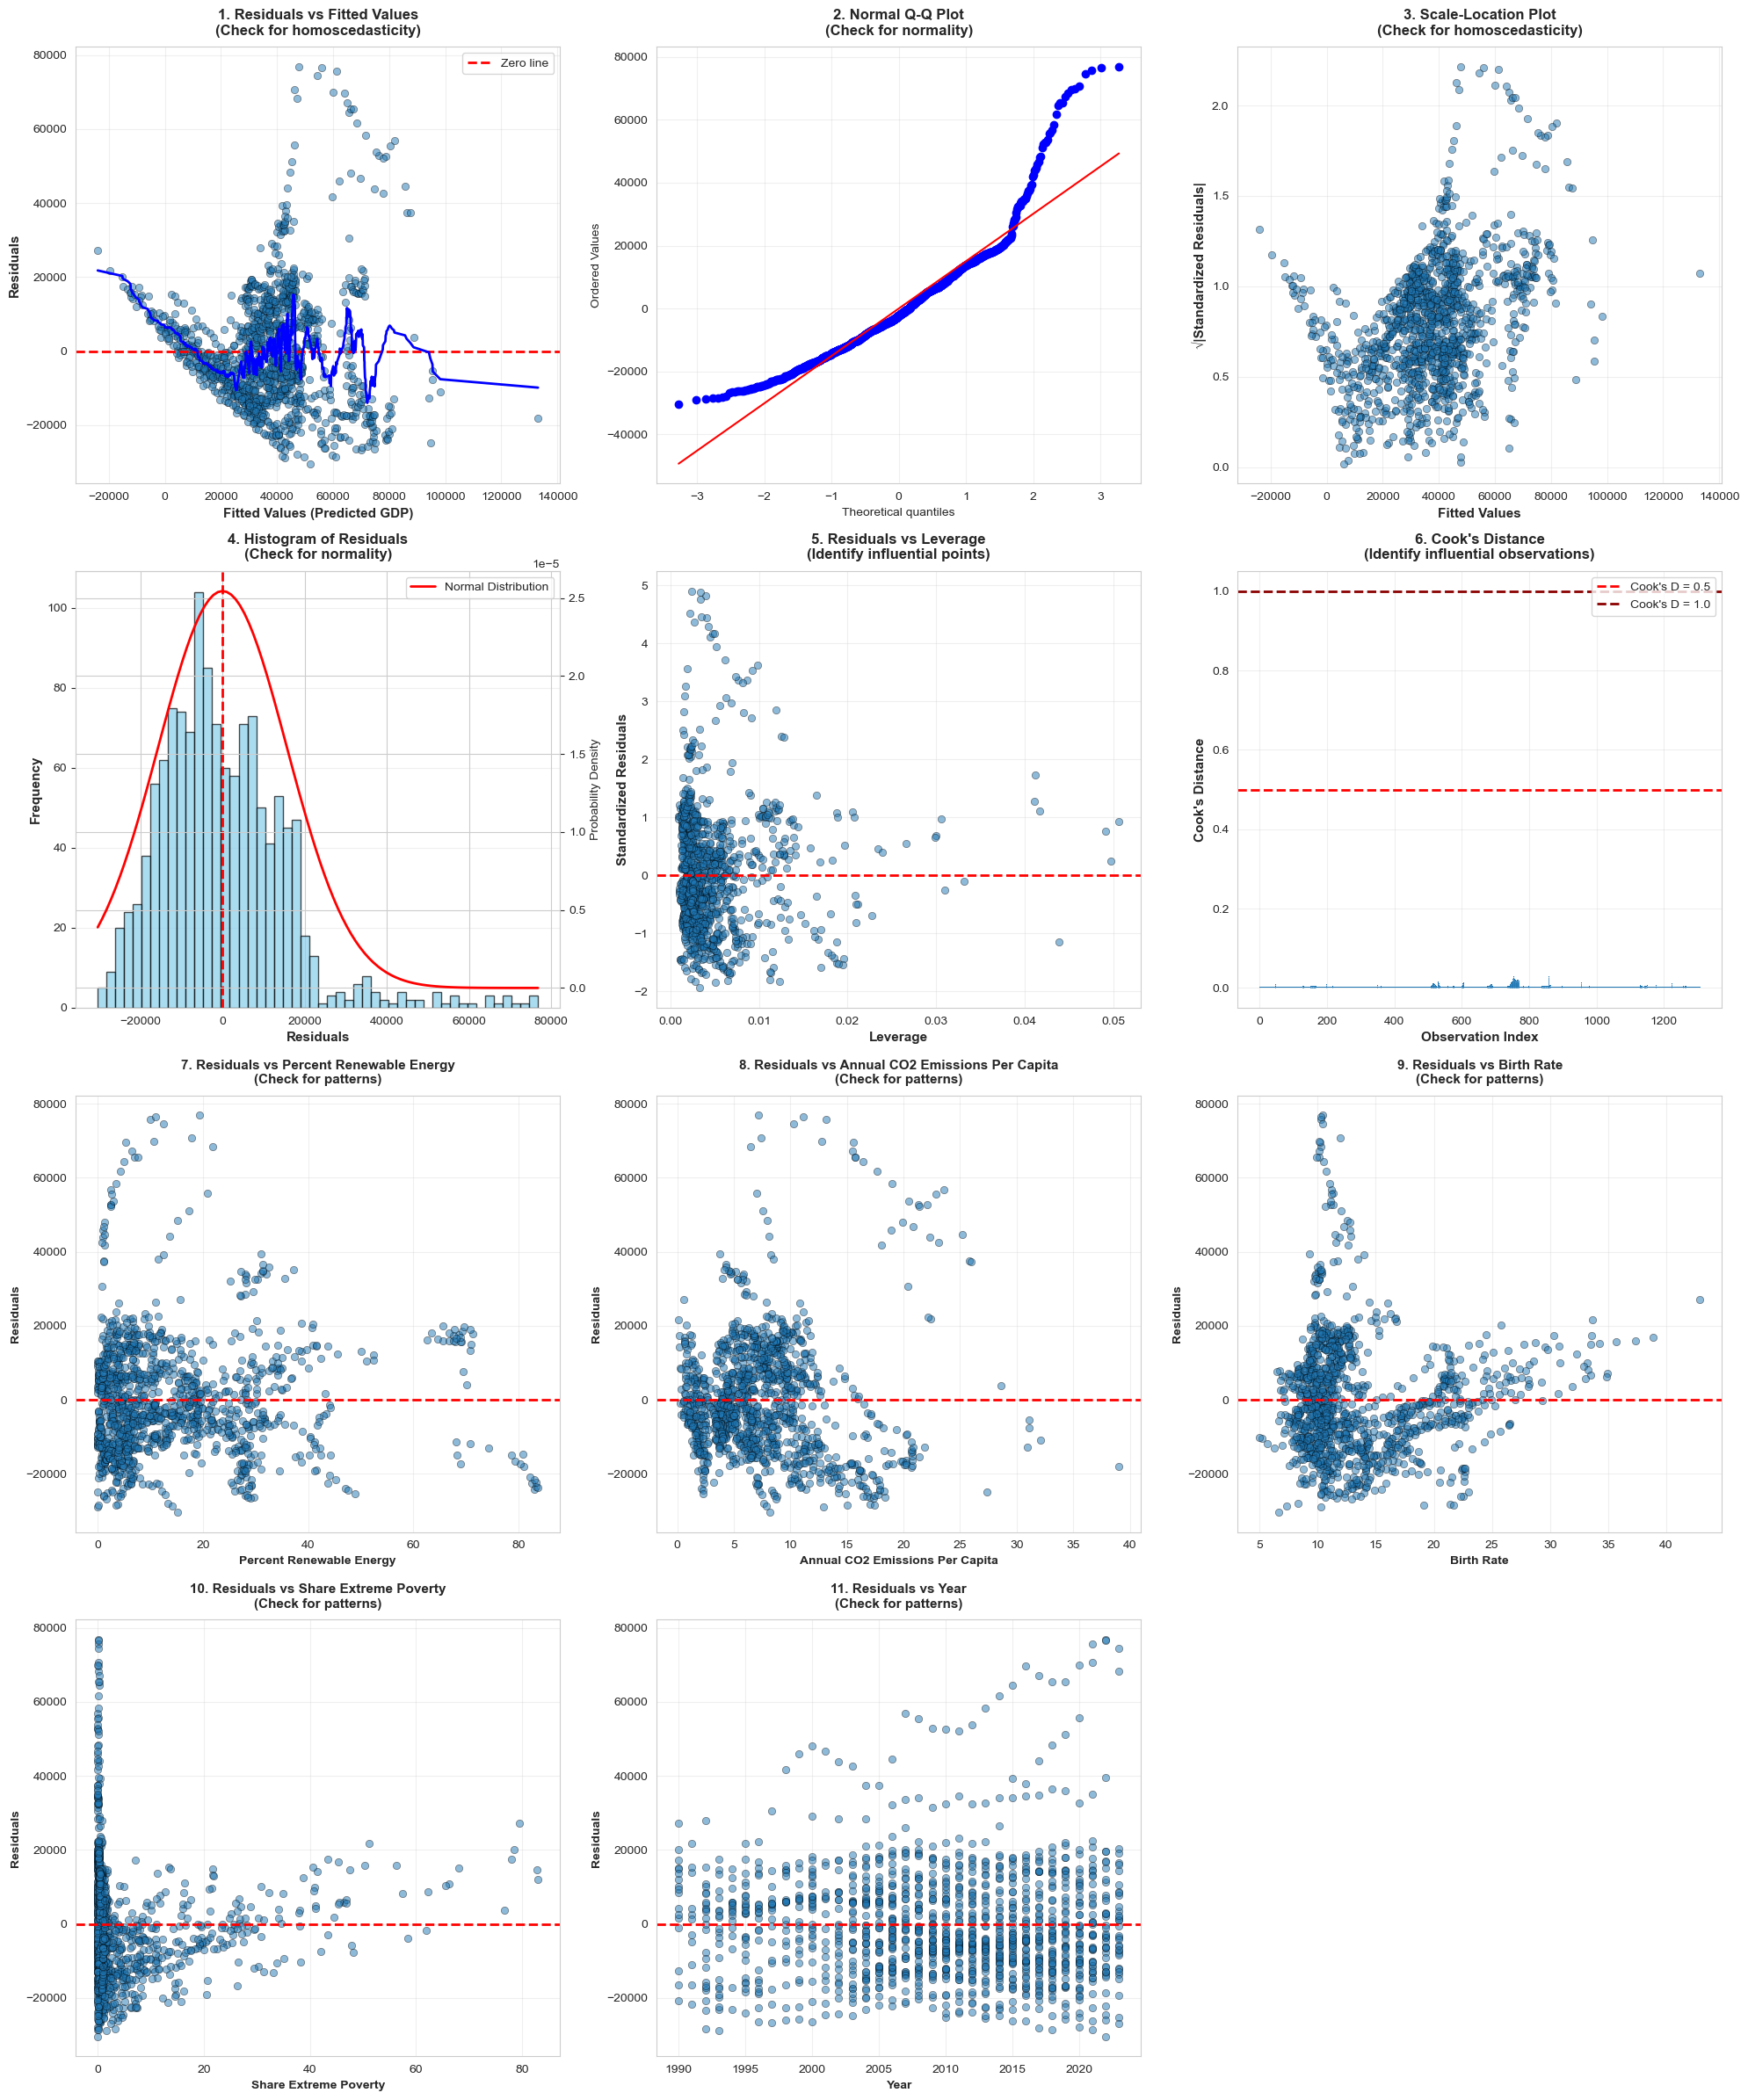

In [5]:
#IMPLEMENTING COMPREHENSIVE RESIDUAL PLOTS - Final Model 

file_path = 'final_dataset.xlsx'
df = pd.read_excel(file_path)
df.columns = df.columns.str.strip()
df = df.dropna()

X_columns = ['Year', 'Annual CO2 Emissions Per Capita', 
             'Birth Rate', 'Percent Renewable Energy', 
             'Share Extreme Poverty']

y_column = 'GDP Per Capita' 

X_columns = list(set(X_columns))  
X_columns = [col for col in X_columns if col != y_column]

X = df[X_columns]
y = df[y_column]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

model = LinearRegression()
model.fit(X_scaled, y)

y_pred = model.predict(X_scaled)
residuals = y - y_pred

standardized_residuals = residuals / np.std(residuals)

X_with_intercept = np.column_stack([np.ones(len(X)), X_scaled])
hat_matrix = X_with_intercept @ np.linalg.inv(X_with_intercept.T @ X_with_intercept) @ X_with_intercept.T
leverage = np.diag(hat_matrix)

n = len(y)
k = X.shape[1]
mse = np.sum(residuals**2) / (n - k - 1)
cooks_d = (standardized_residuals**2 / k) * (leverage / (1 - leverage)**2)

print("\n" + "=" * 80)
print("COMPREHENSIVE RESIDUAL ANALYSIS")
print("=" * 80)

# ============================================================================
# CREATE COMPREHENSIVE RESIDUAL PLOTS
# ============================================================================

sns.set_style("whitegrid")
plt.rcParams['figure.facecolor'] = 'white'

fig = plt.figure(figsize=(20, 24))

# ────────────────────────────────────────────────────────────────────────────
# PLOT 1: Residuals vs Fitted Values
# ────────────────────────────────────────────────────────────────────────────
ax1 = plt.subplot(4, 3, 1)
ax1.scatter(y_pred, residuals, alpha=0.5, edgecolors='k', linewidths=0.5)
ax1.axhline(y=0, color='red', linestyle='--', linewidth=2, label='Zero line')
ax1.set_xlabel('Fitted Values (Predicted GDP)', fontsize=11, fontweight='bold')
ax1.set_ylabel('Residuals', fontsize=11, fontweight='bold')
ax1.set_title('1. Residuals vs Fitted Values\n(Check for homoscedasticity)', 
              fontsize=12, fontweight='bold', pad=10)
ax1.legend()
ax1.grid(True, alpha=0.3)

from scipy.signal import savgol_filter
sorted_idx = np.argsort(y_pred)
if len(y_pred) > 50:
    smoothed = savgol_filter(residuals[sorted_idx], 51, 3)
    ax1.plot(y_pred[sorted_idx], smoothed, color='blue', linewidth=2, label='Trend')

# ────────────────────────────────────────────────────────────────────────────
# PLOT 2: Q-Q Plot (Normal Probability Plot)
# ────────────────────────────────────────────────────────────────────────────
ax2 = plt.subplot(4, 3, 2)
stats.probplot(residuals, dist="norm", plot=ax2)
ax2.set_title('2. Normal Q-Q Plot\n(Check for normality)', 
              fontsize=12, fontweight='bold', pad=10)
ax2.grid(True, alpha=0.3)

# ────────────────────────────────────────────────────────────────────────────
# PLOT 3: Scale-Location Plot (Spread-Location)
# ────────────────────────────────────────────────────────────────────────────
ax3 = plt.subplot(4, 3, 3)
sqrt_std_resid = np.sqrt(np.abs(standardized_residuals))
ax3.scatter(y_pred, sqrt_std_resid, alpha=0.5, edgecolors='k', linewidths=0.5)
ax3.set_xlabel('Fitted Values', fontsize=11, fontweight='bold')
ax3.set_ylabel('√|Standardized Residuals|', fontsize=11, fontweight='bold')
ax3.set_title('3. Scale-Location Plot\n(Check for homoscedasticity)', 
              fontsize=12, fontweight='bold', pad=10)
ax3.grid(True, alpha=0.3)

# ────────────────────────────────────────────────────────────────────────────
# PLOT 4: Histogram of Residuals
# ────────────────────────────────────────────────────────────────────────────
ax4 = plt.subplot(4, 3, 4)
ax4.hist(residuals, bins=50, edgecolor='black', alpha=0.7, color='skyblue')
ax4.axvline(x=0, color='red', linestyle='--', linewidth=2)
ax4.set_xlabel('Residuals', fontsize=11, fontweight='bold')
ax4.set_ylabel('Frequency', fontsize=11, fontweight='bold')
ax4.set_title('4. Histogram of Residuals\n(Check for normality)', 
              fontsize=12, fontweight='bold', pad=10)
ax4.grid(True, alpha=0.3, axis='y')

mu, sigma = residuals.mean(), residuals.std()
x = np.linspace(residuals.min(), residuals.max(), 100)
p = stats.norm.pdf(x, mu, sigma)
ax4_twin = ax4.twinx()
ax4_twin.plot(x, p, 'r-', linewidth=2, label='Normal Distribution')
ax4_twin.set_ylabel('Probability Density', fontsize=10)
ax4_twin.legend()

# ────────────────────────────────────────────────────────────────────────────
# PLOT 5: Residuals vs Leverage (Cook's Distance)
# ────────────────────────────────────────────────────────────────────────────
ax5 = plt.subplot(4, 3, 5)
ax5.scatter(leverage, standardized_residuals, alpha=0.5, edgecolors='k', linewidths=0.5)
ax5.axhline(y=0, color='red', linestyle='--', linewidth=2)
ax5.set_xlabel('Leverage', fontsize=11, fontweight='bold')
ax5.set_ylabel('Standardized Residuals', fontsize=11, fontweight='bold')
ax5.set_title("5. Residuals vs Leverage\n(Identify influential points)", 
              fontsize=12, fontweight='bold', pad=10)
ax5.grid(True, alpha=0.3)

influential = np.where(cooks_d > 0.5)[0]
if len(influential) > 0:
    ax5.scatter(leverage[influential], standardized_residuals[influential], 
                color='red', s=100, label=f'Influential (n={len(influential)})', zorder=5)
    ax5.legend()

# ────────────────────────────────────────────────────────────────────────────
# PLOT 6: Cook's Distance Plot
# ────────────────────────────────────────────────────────────────────────────
ax6 = plt.subplot(4, 3, 6)
stem_lines = ax6.stem(range(len(cooks_d)), cooks_d, markerfmt=',', basefmt=" ")
plt.setp(stem_lines, 'linewidth', 0.5)
ax6.axhline(y=0.5, color='red', linestyle='--', linewidth=2, label="Cook's D = 0.5")
ax6.axhline(y=1.0, color='darkred', linestyle='--', linewidth=2, label="Cook's D = 1.0")
ax6.set_xlabel('Observation Index', fontsize=11, fontweight='bold')
ax6.set_ylabel("Cook's Distance", fontsize=11, fontweight='bold')
ax6.set_title("6. Cook's Distance\n(Identify influential observations)", 
              fontsize=12, fontweight='bold', pad=10)
ax6.legend()
ax6.grid(True, alpha=0.3)

# ────────────────────────────────────────────────────────────────────────────
# PLOTS 7-12: Residuals vs Each Predictor
# ────────────────────────────────────────────────────────────────────────────
for i, col in enumerate(X_columns, start=7):
    if i > 12:  
        break
    
    ax = plt.subplot(4, 3, i)
    ax.scatter(df[col], residuals, alpha=0.5, edgecolors='k', linewidths=0.5)
    ax.axhline(y=0, color='red', linestyle='--', linewidth=2)
    ax.set_xlabel(col, fontsize=10, fontweight='bold')
    ax.set_ylabel('Residuals', fontsize=10, fontweight='bold')
    ax.set_title(f'{i}. Residuals vs {col}\n(Check for patterns)', 
                 fontsize=11, fontweight='bold', pad=10)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('comprehensive_residual_analysis.png', dpi=300, bbox_inches='tight')
print("\n✓ Comprehensive residual plots saved as 'comprehensive_residual_analysis.png'")

# ============================================================================
# RESIDUAL DIAGNOSTICS SUMMARY
# ============================================================================

print("\n" + "=" * 80)
print("RESIDUAL DIAGNOSTICS SUMMARY")
print("=" * 80)

shapiro_stat, shapiro_p = stats.shapiro(residuals)
jarque_bera_stat, jarque_bera_p = stats.jarque_bera(residuals)

print(f"\n1. NORMALITY TESTS:")
print(f"   Shapiro-Wilk Test:")
print(f"     • Statistic: {shapiro_stat:.6f}")
print(f"     • p-value: {shapiro_p:.6e}")
print(f"     • Result: {'✓ Normal' if shapiro_p > 0.05 else '✗ Not Normal'}")

print(f"\n   Jarque-Bera Test:")
print(f"     • Statistic: {jarque_bera_stat:.6f}")
print(f"     • p-value: {jarque_bera_p:.6e}")
print(f"     • Result: {'✓ Normal' if jarque_bera_p > 0.05 else '✗ Not Normal'}")

from scipy.stats import pearsonr
bp_stat, bp_p = pearsonr(y_pred, np.abs(residuals))
print(f"\n2. HOMOSCEDASTICITY:")
print(f"   Correlation test (fitted vs |residuals|):")
print(f"     • Correlation: {bp_stat:.6f}")
print(f"     • p-value: {bp_p:.6e}")
print(f"     • Result: {'✓ Homoscedastic' if bp_p > 0.05 else '✗ Heteroscedastic'}")

print(f"\n3. INFLUENTIAL POINTS:")
print(f"   Cook's Distance > 0.5: {np.sum(cooks_d > 0.5)} observations")
print(f"   Cook's Distance > 1.0: {np.sum(cooks_d > 1.0)} observations")
if np.sum(cooks_d > 0.5) > 0:
    top_influential = np.argsort(cooks_d)[-5:][::-1]
    print(f"\n   Top 5 influential observations:")
    for idx in top_influential:
        print(f"     • Row {idx}: {df['Country'].iloc[idx]} ({df['Year'].iloc[idx]}) - Cook's D = {cooks_d[idx]:.4f}")

outliers_std = np.abs(standardized_residuals) > 3
print(f"\n4. OUTLIERS:")
print(f"   |Standardized Residuals| > 3: {np.sum(outliers_std)} observations ({np.sum(outliers_std)/len(residuals)*100:.2f}%)")

print(f"\n5. RESIDUAL STATISTICS:")
print(f"   Mean: {residuals.mean():.6f} (should be ≈ 0)")
print(f"   Std Dev: {residuals.std():.6f}")
print(f"   Min: {residuals.min():.2f}")
print(f"   Max: {residuals.max():.2f}")
print(f"   Range: {residuals.max() - residuals.min():.2f}")

print("\n" + "=" * 80)
print("✓ RESIDUAL ANALYSIS COMPLETE")
print("=" * 80)